### Project Description : This is competition hosted by Data Driven. The objective is to predict which water pumps are functional, which need some repairs, and which don't work at all, a multiclass classifcation problem. The model produced managed to get 81.06% accuracy on test data, currently on top 14% of the leaderboeard.

##### This training use CatBoost Model, under family of boosting tree model, invented in year 2017 by a Russian company, Yandex. It is famous for its power and ability to do categorical features preprocessing directly, unlike other memebrs in the gradient boosting family which make the essence of CatBoost model.

#### 1. Import Dependencies Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import xgboost as xgb
import catboost

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from fancyimpute import IterativeImputer as MICE
from datetime import datetime
from catboost import Pool, CatBoostClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
Using TensorFlow backend.


### 2. Load train & test set data

In [3]:
df_train = pd.read_csv("drive/My Drive/Data_Interchange/train_taarifa.csv",parse_dates=True)
y_train = pd.read_csv("drive/My Drive/Data_Interchange/y_train.csv")
df_test = pd.read_csv("drive/My Drive/Data_Interchange/test_taarifa.csv",parse_dates=True)
df_full = pd.concat([df_train,df_test],sort=False).drop('status_group',axis=1)

df_train_index = df_train.index.values
df_test_index = df_test.index.values

print(df_full.shape)
print(df_train.shape)
print(y_train.shape)
print(df_test.shape)

(74250, 40)
(59400, 41)
(59400, 2)
(14850, 40)


### 3. Exploratory Data Analysis

In [0]:
df_train.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

In [0]:
# Check if there is any missing data
# There are 7 columns with missing data
df_train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [0]:
# Check the counts of target variable

df_train.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

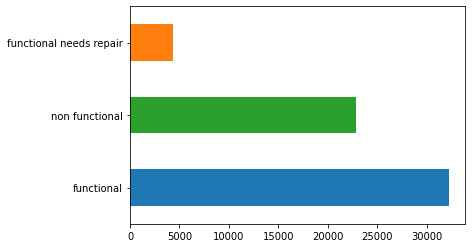

In [4]:
# Plot the bar chart to visualize target "status_group"

palette=[sns.color_palette()[0],sns.color_palette()[2],sns.color_palette()[1]]
y_train.status_group.value_counts().plot(kind='barh', color=palette)

Text(0.5, 0, 'Construction Year')

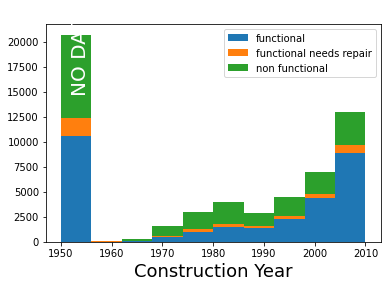

In [5]:
# Plot the bar chart to visualize target "status_group" & relationship with "construction_year"

df_train.construction_year=pd.to_numeric(df_train.construction_year)
df_train.loc[df_train.construction_year <= 0, df_train.columns=='construction_year'] = 1950

hist1=df_train[df_train.status_group == 'functional'].construction_year
hist2=df_train[df_train.status_group == 'functional needs repair'].construction_year
hist3=df_train[df_train.status_group == 'non functional'].construction_year

n,b,p=plt.hist([hist1, hist2, hist3], stacked=True,range=[1950,2010])
plt.legend(['functional','functional needs repair','non functional'],loc=0)
plt.text(1952, 15000,'NO DATA',fontsize=20,rotation=90,color='white')
plt.xlabel('Construction Year', fontsize=18)

In [0]:
#convert status group label into numerical data

val_status_group={'functional':2, 'functional needs repair':1,
                   'non functional':0}
df_train['status_group_vals']=df_train.status_group.replace(val_status_group)

##### Remove the field which has too many redundant values/ categories

### 3. Data Transformation - Part 1

##### Fill the blank categorical column with "Unknown"/"Other"

In [0]:
df_train.funder = df_train.funder.fillna('other')
df_test.funder = df_test.funder.fillna('other')

df_train.installer = df_train.installer.fillna('other')
df_test.installer = df_test.installer.fillna('other')

df_train.scheme_management = df_train.scheme_management.fillna('other')
df_test.scheme_management = df_test.scheme_management.fillna('other')

In [0]:
# Turn construction_year into a categorical column containing the following values: '60s', '70s',
# '80s', '90s, '00s', '10s', 'unknown'.

def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
df_train['construction_year'] = df_train.apply(lambda row: construction_wrangler(row), axis=1)
df_test['construction_year'] = df_test.apply(lambda row: construction_wrangler(row), axis=1)

##### Drop the columns which are redundant columns with too many unique values, this would not bring any goods to model

In [0]:
# Eg. A few pairs of variables are similar :
# (waterpoint_type,waterpoint_type_group) & (source & source type) & etcs both are almost similar, can drop one of them

df_train=df_train.drop(['subvillage','scheme_name','recorded_by','waterpoint_type','source','quantity',
                        'payment','management','extraction_type','extraction_type_group'],axis=1)
df_test=df_test.drop(['subvillage','scheme_name','recorded_by','waterpoint_type','source','quantity',
                      'payment','management','extraction_type','extraction_type_group'],axis=1)

##### Fill the valid columns with blank value - "Unknown"/"Other"

In [0]:
#Since most of the values are True, as of now lets insert True for the missing values. Scope to alter the values in future
df_train.public_meeting = df_train.public_meeting.fillna('Unknown')
df_test.public_meeting = df_test.public_meeting.fillna('Unknown')

In [0]:
df_train.scheme_management = df_train.scheme_management.fillna('other')
df_test.scheme_management = df_test.scheme_management.fillna('other')

In [0]:
# We only have two values here: true and false. This one can stay but we'll have to replace 
# the unknown data with a string value.

df_train.permit = df_train.permit.fillna('Unknown')
df_test.permit = df_test.permit.fillna('Unknown')

In [13]:
#EDA
# Checking Null Values on test data
df_train.apply(lambda x: sum(x.isnull()), axis=0)

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
scheme_management        0
permit                   0
construction_year        0
extraction_type_class    0
management_group         0
payment_type             0
water_quality            0
quality_group            0
quantity_group           0
source_type              0
source_class             0
waterpoint_type_group    0
status_group             0
status_group_vals        0
dtype: int64

In [14]:
# Statistics for full train/test dataset
df_full.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [0]:
### Imputation for invalid value 0 in numerical column with mean/median

# amount_tsh median equal to 0, no replacement done in first consideration 

def population_cleaning(train):
    if train['population']==0:
        return 25 #replace with median, skewed data
    else:
        return train['population']

def gpsheight_cleaning(train):
    if train['gps_height']==0:
        return 364 #replace with median, skewed data
    else:
        return train['gps_height']

def longitude_cleaning(train):
    if train['longitude']==0:
        return 34.074262
    else:
        return train['longitude']

df_train['population']= df_train.apply(lambda row: population_cleaning(row), axis=1)
df_test['population']= df_test.apply(lambda row: population_cleaning(row), axis=1)
df_train['gps_height']= df_train.apply(lambda row: gpsheight_cleaning(row), axis=1)
df_test['gps_height']= df_test.apply(lambda row: gpsheight_cleaning(row), axis=1)
df_train['longitude']= df_train.apply(lambda row: longitude_cleaning(row), axis=1)
df_test['longitude']= df_test.apply(lambda row: longitude_cleaning(row), axis=1)

### Feature engineering: Days since recorded can be useful to know the period of pump installed

In [16]:
df_train.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(df_train.date_recorded)
df_train.columns = ['days_since_recorded' if x == 'date_recorded' else x for x in df_train.columns]
df_train.days_since_recorded = df_train.days_since_recorded.astype('timedelta64[D]').astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [17]:
df_test.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(df_test.date_recorded)
df_test.columns = ['days_since_recorded' if x == 'date_recorded' else x for x in df_test.columns]
df_test.days_since_recorded = df_test.days_since_recorded.astype('timedelta64[D]').astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [0]:
# Data is clean for model training
# not too correlated to each other, good fit for model
df_train.corr()

,id,amount_tsh,days_since_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,status_group_vals
id,1.000000,-0.005321,-0.003174,-0.004692,-0.001348,0.001718,-0.002629,-0.003028,-0.003044,-0.002813,-0.004049
amount_tsh,-0.005321,1.000000,0.016346,0.076650,0.022134,-0.052670,0.002944,-0.026813,-0.023599,0.016288,0.053702
days_since_recorded,-0.003174,0.016346,1.000000,-0.254247,0.036293,-0.231637,0.018206,-0.155157,0.016448,-0.109340,0.031476
gps_height,-0.004692,0.076650,-0.254247,1.000000,0.149155,-0.035751,0.007237,-0.183521,-0.171233,0.135003,0.114029
longitude,-0.001348,0.022134,0.036293,0.149155,1.000000,-0.425802,0.023873,0.034197,0.151398,0.086590,-0.004366
latitude,0.001718,-0.052670,-0.231637,-0.035751,-0.425802,1.000000,0.006837,-0.221018,-0.201020,-0.022152,0.014547
num_private,-0.002629,0.002944,0.018206,0.007237,0.023873,0.006837,1.000000,-0.020377,-0.004478,0.003818,0.005021
region_code,-0.003028,-0.026813,-0.155157,-0.183521,0.034197,-0.221018,-0.020377,1.000000,0.678602,0.094088,-0.108640
district_code,-0.003044,-0.023599,0.016448,-0.171233,0.151398,-0.201020,-0.004478,0.678602,1.000000,0.061831,-0.065687
population,-0.002813,0.016288,-0.109340,0.135003,0.086590,-0.022152,0.003818,0.094088,0.061831,1.000000,0.017759


In [0]:
#water_quality and quality_group are correlated . drop one of them
df_train=df_train.drop(['quality_group'],axis=1)
df_test=df_test.drop(['quality_group'],axis=1)

In [0]:
# Lastly drop those variable that seem superflous like 'num_private' & 'wpt_name which no extra info
df_train1 = df_train.copy()
df_train = df_train.drop(['num_private','wpt_name','status_group'], axis=1)

df_test = df_test.drop(['num_private','wpt_name'], axis=1)

In [20]:
print('Shape of training data',df_train.shape)
print('Shape of testing data',df_test.shape)

Shape of training data (59400, 28)
Shape of testing data (14850, 27)


In [0]:
# Define Y & drop it from the train set for feature selection
target = df_train.status_group_vals
df_train = df_train.drop('status_group_vals', axis=1)

df_train1=df_train.copy()

In [0]:
# # Invalid value like 0 in some columns detected, will be imputed with IterativeImputer later

# def population_cleaning(train):
#     if train['population']==0:
#         return np.nan
#     else:
#         return train['population']

# def gpsheight_cleaning(train):
#     if train['gps_height']==0:
#         return np.nan
#     else:
#         return train['gps_height']

# def longitude_cleaning(train):
#     if train['longitude']==0:
#         return np.nan
#     else:
#         return train['longitude']

# def amounttsh_cleaning(train):
#     if train['amount_tsh']==0:
#         return np.nan
#     else:
#         return train['amount_tsh']

# df_train['population']= df_train.apply(lambda row: population_cleaning(row), axis=1)
# df_test['population']= df_test.apply(lambda row: population_cleaning(row), axis=1)
# df_train['gps_height']= df_train.apply(lambda row: gpsheight_cleaning(row), axis=1)
# df_test['gps_height']= df_test.apply(lambda row: gpsheight_cleaning(row), axis=1)
# df_train['longitude']= df_train.apply(lambda row: longitude_cleaning(row), axis=1)
# df_test['longitude']= df_test.apply(lambda row: longitude_cleaning(row), axis=1)
# df_train['amount_tsh']= df_train.apply(lambda row: amounttsh_cleaning(row), axis=1)
# df_test['amount_tsh']= df_test.apply(lambda row: amounttsh_cleaning(row), axis=1)

In [0]:
# to test out normalization and scaler
df_train1 = df_train.copy()
df_test1 = df_test.copy()

### 5. Split Data into train & validation set

In [0]:
X_train, X_val, y_train, y_val = train_test_split(df_train1, target, train_size=0.9,random_state=100)

##### Perform Data Transformation - Part 2 (after train_test_split)

##### In this case, IterativeImputer only manage to give accuracy of 80.4% hence will no proceed.

In [0]:
# # FancyImpute with MICE
# # Default method used is BayesianRidge

# # Use Logistic regression as the baseline
# logreg = make_pipeline(RobustScaler(), LogisticRegression())

# # Impute invalid/missing value
# # Fit_transform on training set
# mice = MICE(verbose=0)
# X_train_fancy_mice = mice.fit_transform(X_train)
# scores = cross_val_score(logreg, X_train_fancy_mice, y_train, cv=10)
# scores.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.72334455667789

In [0]:
# # Then apply transformation to validation and test dataset to avoid data leakage
# col_list = X_train.columns.tolist()
# X_train_mice = pd.DataFrame(X_train_fancy_mice, columns=col_list)
# print(X_train_mice.shape)

# X_train_mice.head()

(53460, 76)


,id,amount_tsh,days_since_recorded,gps_height,longitude,latitude,region_code,district_code,population,funder_danida,funder_government,funder_other,funder_rwssp,funder_world_bank,installer_commu,installer_dwe,installer_government,installer_other,installer_rwe,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,basin_Rufiji,basin_Ruvuma / Southern Coast,basin_Wami / Ruvu,public_meeting_False,public_meeting_True,public_meeting_Unknown,scheme_management_other,scheme_management_vwc,scheme_management_wtr_auth,scheme_management_wtr_brd,scheme_management_wua,scheme_management_wug,permit_False,permit_True,permit_Unknown,construction_year_00s,construction_year_10s,construction_year_70s,construction_year_80s,construction_year_90s,construction_year_unknown,extraction_type_class_gravity,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_submersible,management_group_commercial,management_group_user-group,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_per bucket,payment_type_unknown,water_quality_salty,water_quality_soft,water_quality_unknown,quantity_group_dry,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown,source_type_borehole,source_type_rainwater harvesting,source_type_river/lake,source_type_shallow well,source_type_spring,source_class_groundwater,source_class_surface,waterpoint_type_group_communal standpipe,waterpoint_type_group_improved spring,waterpoint_type_group_other
0,61731.0,0.0,263.0,993.0,36.798678,-3.493768,2.0,2.0,300.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
1,48281.0,2000.0,873.0,1133.0,31.159952,-6.374470,15.0,1.0,240.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,37715.0,0.0,1029.0,760.0,30.576431,-6.998989,15.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,27455.0,750.0,123.0,1071.0,29.872486,-4.621343,16.0,2.0,1500.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,62597.0,0.0,961.0,1599.0,35.121040,-9.248569,11.0,4.0,480.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [0]:
# # Apply transformation on validation & test dataset

# X_val_fancy_mice = mice.transform(X_val)
# df_test_fancy_mice = mice.transform(df_test)

# X_val_mice = pd.DataFrame(X_val_fancy_mice, columns=col_list)
# df_test_mice = pd.DataFrame(df_test_fancy_mice, columns=col_list)
# print(X_val_mice.shape)
# print(df_test_mice.shape)

(5940, 76)
(14850, 76)


##### Data Normalization

In [0]:
# Columns intended for normalization
df_num_cols=['amount_tsh','days_since_recorded','longitude','region_code', 'latitude',                      
'district_code','population']

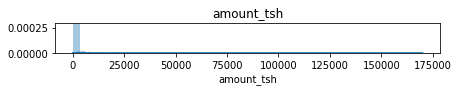

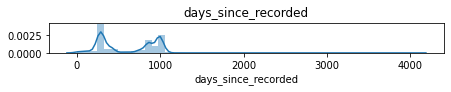

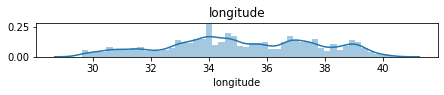

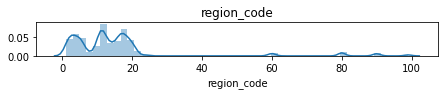

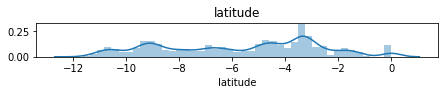

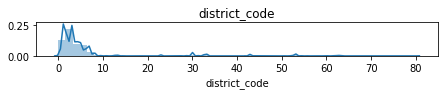

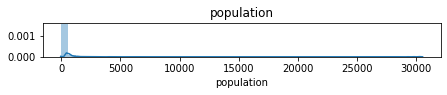

In [26]:
# Plot the distribution of numerical columns

for i, col in enumerate(df_num_cols):
    plt.figure(figsize=(12,5))
    plt.subplot(5, 2, i + 1)
    sns.distplot(X_train[col])
    plt.title(str(col))
    plt.subplots_adjust(hspace=0.8, wspace=0.5)
    plt.tight_layout()
    plt.show()
plt.show()

In [0]:
# # fig=plt.figure(figsize=(20,20))
# for i, col in enumerate(df_full[numeric_col]):
#     # ax = fig.add_subplot(2,6,i+1)
#     plt.figure(i)
#     sns.distplot(df_full[col])

# # fig.tight_layout()
# # plt.show()

In [27]:
# Do normalization and scaling

# Train set normalization
X_train.amount_tsh = X_train.amount_tsh.apply(lambda x: np.log10(x+1))
X_train.days_since_recorded = X_train.days_since_recorded.apply(lambda x: np.log10(x+1))
X_train.longitude = X_train.longitude.apply(lambda x: np.log10(x+1))
X_train.region_code = X_train.region_code.apply(lambda x: np.log10(x+1))
X_train.district_code = X_train.district_code.apply(lambda x: np.log10(x+1))
X_train.population = X_train.population.apply(lambda x: np.log10(x+1))


# Validation set normalization
X_val.amount_tsh = X_val.amount_tsh.apply(lambda x: np.log10(x+1))
X_val.days_since_recorded = X_val.days_since_recorded.apply(lambda x: np.log10(x+1))
X_val.longitude = X_val.longitude.apply(lambda x: np.log10(x+1))
X_val.region_code = X_val.region_code.apply(lambda x: np.log10(x+1))
X_val.district_code = X_val.district_code.apply(lambda x: np.log10(x+1))
X_val.population = X_val.population.apply(lambda x: np.log10(x+1))

# Test set normalization
df_test1.amount_tsh = df_test.amount_tsh.apply(lambda x: np.log10(x+1))
df_test1.days_since_recorded = df_test.days_since_recorded.apply(lambda x: np.log10(x+1))
df_test1.longitude = df_test.longitude.apply(lambda x: np.log10(x+1))
df_test1.region_code = df_test.region_code.apply(lambda x: np.log10(x+1))
df_test1.district_code = df_test.district_code.apply(lambda x: np.log10(x+1))
df_test1.population = df_test.population.apply(lambda x: np.log10(x+1))

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [0]:
df_train1=df_train1.fillna(df_train1.mean())
df_test1=df_test1.fillna(df_test1.mean())

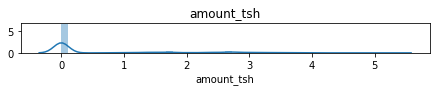

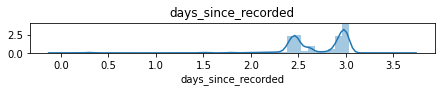

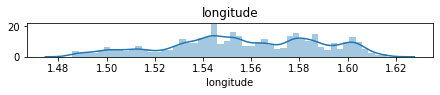

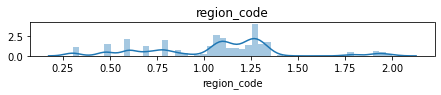

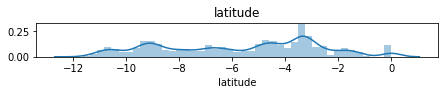

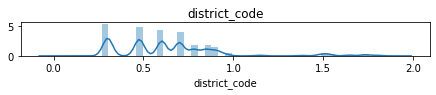

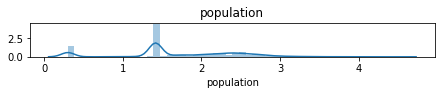

In [29]:
# Data distribution after normalization

for i, col in enumerate(df_num_cols):
    plt.figure(figsize=(12,5))
    plt.subplot(5, 2, i + 1)
    sns.distplot(X_train[col])
    plt.title(str(col))
    plt.subplots_adjust(hspace=0.8, wspace=0.5)
    plt.tight_layout()
    plt.show()
plt.show()

##### Data Scaling

In [0]:
# Scale the numerical variables can help model find pattern and faster convergence
# Tree-like algorithms is still prone to unnormalized/unscaled data due to bagging & boosting
rs =RobustScaler()

# Fit_transform should be done on only training data to avoid data leakage problem
X_train[df_num_cols] = rs.fit_transform(X_train[df_num_cols])

X_val[df_num_cols] = rs.transform(X_val[df_num_cols])
df_test1[df_num_cols] = rs.transform(df_test1[df_num_cols])

##### Data are now good to proceed to model training ...

### 6. Model Training

In [37]:
# Need to pass in the index of categorical features, elase they will be treated as numeric

cat_features = [3,5,8,9,12,13,15,16,17,18,19,20,21,22,23,24,25,26]

cbc = CatBoostClassifier(
                         loss_function='MultiClass',
                         eval_metric='Accuracy', # or"AUC"
                         leaf_estimation_method='Newton',
                         random_strength=0.1, #0.1
                         learning_rate=0.07,
                         random_seed=103734,
                        #  subsample=1.0,
                         grow_policy='Depthwise', 
                        #  class_weights=[0.39,0.07,0.54],
                         rsm=0.6,
                         classes_count=3,
                         min_data_in_leaf=2,
                        #  langevin=True,
                         l2_leaf_reg = 3, #0.01
                         bagging_temperature=1, #bootstrap aggressiveness
                        #  leaf_estimation_iterations=5, #another parameter for faster training time
                         depth=8, #15
                         border_count=254,
                         verbose=True
                        #  iterations=100,
                        #  one_hot_max_size=31, #bigger reduce training time, >this thres change to onehot
                        #  max_ctr_complexity=2, #reduce trraining time to only produce two pattern combination
                         )
        

cbc.fit(X_train, 
        y_train,
        cat_features=cat_features,
        logging_level='Verbose',
        eval_set=(X_val, y_val),
        # early_stopping_rounds=100,
        use_best_model=True,
        plot=True)

print("Count of trees in model = {}".format(cbc.tree_count_))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7365320	test: 0.7422559	best: 0.7422559 (0)	total: 304ms	remaining: 5m 3s
1:	learn: 0.7415077	test: 0.7459596	best: 0.7459596 (1)	total: 549ms	remaining: 4m 34s
2:	learn: 0.7414516	test: 0.7447811	best: 0.7459596 (1)	total: 796ms	remaining: 4m 24s
3:	learn: 0.7422559	test: 0.7452862	best: 0.7459596 (1)	total: 1.02s	remaining: 4m 13s
4:	learn: 0.7443509	test: 0.7466330	best: 0.7466330 (4)	total: 1.26s	remaining: 4m 11s
5:	learn: 0.7439581	test: 0.7462963	best: 0.7466330 (4)	total: 1.5s	remaining: 4m 8s
6:	learn: 0.7445380	test: 0.7473064	best: 0.7473064 (6)	total: 1.72s	remaining: 4m 4s
7:	learn: 0.7447063	test: 0.7468013	best: 0.7473064 (6)	total: 1.96s	remaining: 4m 2s
8:	learn: 0.7442013	test: 0.7466330	best: 0.7473064 (6)	total: 2.17s	remaining: 3m 59s
9:	learn: 0.7458100	test: 0.7483165	best: 0.7483165 (9)	total: 2.43s	remaining: 4m
10:	learn: 0.7482791	test: 0.7528620	best: 0.7528620 (10)	total: 2.67s	remaining: 3m 59s
11:	learn: 0.7504863	test: 0.7550505	best: 0.75505

In [38]:
# Print Feature Importance

train_pool = Pool(X_train, y_train, cat_features=cat_features)
feature_importances = cbc.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

quantity_group: 18.846732664731114
ward: 12.839039133178987
waterpoint_type_group: 7.7179984226797185
lga: 6.811527821925894
extraction_type_class: 4.719662204767611
latitude: 4.53765714383259
longitude: 4.311762508022052
funder: 4.2570028917980824
days_since_recorded: 3.648401555881685
installer: 3.634811305342588
construction_year: 3.1074990720299844
source_type: 2.982204697265265
gps_height: 2.9694223774125694
payment_type: 2.883193636939703
population: 2.394282667067385
id: 2.3050870699284136
region: 1.842262397645389
scheme_management: 1.4016574012699645
basin: 1.357837391979662
district_code: 1.3081176662145704
amount_tsh: 1.2972830877081944
region_code: 1.2415679179426353
public_meeting: 0.8423406355166684
permit: 0.8344545346344924
water_quality: 0.7247745242982844
management_group: 0.7182275993156011
source_class: 0.46519167067091965


 1) quantity_group                 18.846733
 2) ward                           12.839039
 3) waterpoint_type_group          7.717998
 4) lga                            6.811528
 5) extraction_type_class          4.719662
 6) latitude                       4.537657
 7) longitude                      4.311763
 8) funder                         4.257003
 9) days_since_recorded            3.648402
10) installer                      3.634811
11) construction_year              3.107499
12) source_type                    2.982205
13) gps_height                     2.969422
14) payment_type                   2.883194
15) population                     2.394283
16) id                             2.305087
17) region                         1.842262
18) scheme_management              1.401657
19) basin                          1.357837
20) district_code                  1.308118
21) amount_tsh                     1.297283
22) region_code                    1.241568
23) public_meeting            

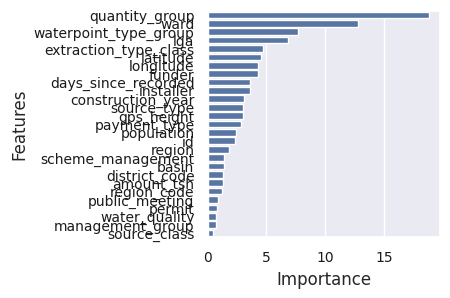

In [39]:
# Plotting

sns.set(font_scale=2)

def func_plot_importance(df_imp):

    sns.set(font_scale=1)
    fig = plt.figure(figsize=(3, 3), dpi=100)
    ax = sns.barplot(
        x="Importance", y="Features", data=df_imp, label="Total", color="b")
    ax.tick_params(labelcolor='k', labelsize='10', width=3)
    plt.show()

def display_importance(model_out, columns, printing=True, plotting=True):
    importances = model_out.feature_importances_
    indices = np.argsort(importances)[::-1]
    importance_list = []
    for f in range(len(columns)):
        importance_list.append((columns[indices[f]], importances[indices[f]]))
        if printing:
            print("%2d) %-*s %f" % (f + 1, 30, columns[indices[f]],
                                    importances[indices[f]]))
    if plotting:
        df_imp = pd.DataFrame(
            importance_list, columns=['Features', 'Importance'])
        func_plot_importance(df_imp)
        

display_importance(model_out=cbc, columns=X_train.columns)

In [40]:
cbc.best_iteration_, cbc.best_score_, cbc.tree_count_

(983,
 {'learn': {'Accuracy': 0.8676206509539843, 'MultiClass': 0.3586350811944778},
  'validation': {'Accuracy': 0.8038720538720538,
   'MultiClass': 0.4917486157028072}},
 984)

In [41]:
# Training & Validation accuracy

from sklearn import metrics

def auc2(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict_proba(train),multi_class="ovr"),
                            metrics.roc_auc_score(y_val,m.predict_proba(test),multi_class='ovr'))
auc2(cbc, X_train, X_val)

(0.9521817031671486, 0.896099472878873)

### Final Model for submission : 

In [42]:
catboost_pred=cbc.predict(df_test1)
test_df = pd.DataFrame(catboost_pred,columns=['status_group'])

test_df['status_group'].value_counts()

2    9127
0    5246
1     477
Name: status_group, dtype: int64

In [0]:
predict_cbc1 = pd.concat([test_df, df_test1], axis=1)

predict_cbc1a = predict_cbc1[['id','status_group']]
predict_cbc1a = predict_cbc1a.astype({"id":'object', "status_group":'object'}) 

def parse_values(x):
    if x == 2: 
        return 'functional'
    elif x == 1: 
        return 'functional needs repair'
    elif x == 0: 
        return 'non functional'

predict_cbc1a['status_group'] = predict_cbc1a['status_group'].apply(parse_values)

predict_cbc1a = predict_cbc1a.reset_index(drop=True).set_index('id')

predict_cbc1a.to_csv('pred_cbc4.csv') 

!cp pred_cbc4.csv "drive/My Drive/Data_Interchange"